## Preconditioner Creation

### ReLU

In [ ]:
import torch
import numpy as np

def create_T_torch(m, device='cuda'):
    """Create a tridiagonal Toeplitz matrix on GPU with pattern [1, -2, 1]."""
    main_diag = -2 * torch.ones(m, device=device)
    upper_diag = torch.ones(m-1, device=device)
    lower_diag = torch.ones(m-1, device=device)

    T = torch.diag(main_diag, diagonal=0)
    T = T + torch.diag(upper_diag, diagonal=1)
    T = T + torch.diag(lower_diag, diagonal=-1)
    return T

def create_preconditioner_B2_with_minus_T_torch(N, device='cuda'):
    """Create block-diagonal preconditioner matrix B on GPU."""
    minus_T_N = -create_T_torch(N, device)

    # Kronecker product for parameter block
    T_kron = torch.kron(minus_T_N, minus_T_N)

    # Create block diagonal matrix
    blocks = [minus_T_N, minus_T_N, T_kron, minus_T_N, minus_T_N, torch.ones(1, device=device)]
    total_size = sum(b.shape[0] for b in blocks)
    B = torch.zeros((total_size, total_size), device=device)

    offset = 0
    for block in blocks:
        size = block.shape[0]
        B[offset:offset+size, offset:offset+size] = block
        offset += size

    return B

def is_symmetric_positive_definite_torch(A, tol=1e-8):
    """Check if matrix is symmetric positive definite using PyTorch."""
    if not torch.allclose(A, A.T, atol=tol):
        return False
    try:
        torch.linalg.cholesky(A)
        return True
    except torch.linalg.LinAlgError:
        return False

In [ ]:
B_test = create_preconditioner_B2_with_minus_T_torch(5)
is_symmetric_positive_definite_torch(B_test)

True

### tanh

In [ ]:
def first_difference_operator(n: int) -> torch.Tensor:
    # Start with the identity matrix
    D = torch.eye(n)

    # Set the superdiagonal entries to -1 for rows 0 to n-2
    indices = torch.arange(n - 1)
    D[indices, indices + 1] = -1

    # Set the periodic boundary condition: the last row subtracts the first element.
    # D[n - 1, 0] = -1

    return D

# # Example usage:
# n = 5
# D = first_difference_operator(n)
# print(D)


def create_preconditioner_tanh_with_T_first_torch(N, device='cuda'):
    """Create block-diagonal preconditioner matrix B on GPU."""
    T_N = first_difference_operator(N)

    # Kronecker product for parameter block
    T_kron = torch.kron(T_N, T_N)

    # Create block diagonal matrix
    blocks = [T_N, T_N, T_kron, T_N, T_N, torch.ones(1, device=device)]
    total_size = sum(b.shape[0] for b in blocks)
    B = torch.zeros((total_size, total_size), device=device)

    offset = 0
    for block in blocks:
        size = block.shape[0]
        B[offset:offset+size, offset:offset+size] = block
        offset += size

    return B

In [ ]:
B_test2 = create_preconditioner_tanh_with_T_first_torch(2)
B_test2

tensor([[ 1., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  1., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  1., -1., -1.,  1.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  1., -0., -1.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0., -0.,  1., -1.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., -1.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., -1.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]],
       device='cuda:0')

### ReLU^3

In [ ]:
import torch

def _fill_diagonal_(M: torch.Tensor, v: torch.Tensor, offset: int) -> None:
    """
    In-place helper that writes the 1-D tensor `v` to the diagonal of `M`
    indicated by `offset` (negative = below main, positive = above).
    """
    n = M.size(0)
    if offset >= 0:                        # super-diagonal
        rows = torch.arange(n - offset, device=M.device)
        cols = rows + offset
    else:                                  # sub-diagonal
        offset = -offset
        cols = torch.arange(n - offset, device=M.device)
        rows = cols + offset
    M[rows, cols] = v


def create_banded_matrix_torch(n: int,
                               *,
                               device=None,
                               dtype=torch.float32) -> torch.Tensor:
    """
    Construct the n×n banded matrix

        [ …  1 −4  6 −4  1 … ]

    with offsets −2, −1, 0, +1, +2 and values 1, −4, 6, −4, 1 respectively.
    Returns a *dense* tensor; call `.to_sparse()` afterwards if you want CSR/COO.
    """
    A = torch.zeros((n, n), device=device, dtype=dtype)

    specs = [
        ( torch.full((n - 2,),  1., device=device, dtype=dtype), -2 ),
        ( torch.full((n - 1,), -4., device=device, dtype=dtype), -1 ),
        ( torch.full((n,     ),  6., device=device, dtype=dtype),  0 ),
        ( torch.full((n - 1,), -4., device=device, dtype=dtype),  1 ),
        ( torch.full((n - 2,),  1., device=device, dtype=dtype),  2 ),
    ]

    for diag_vals, offset in specs:
        _fill_diagonal_(A, diag_vals, offset)

    return A


def create_preconditioner_for_cube_torch(N: int,
                                         *,
                                         device=None,
                                         dtype=torch.float32) -> torch.Tensor:
    """
    Assemble the block-diagonal preconditioner

        B = diag( T, T, T⊗T, T, T, 1)

    where each T is the banded matrix above.
    """
    I_N = torch.eye(N, device=device, dtype=dtype)
    T_N   = create_banded_matrix_torch(N, device=device, dtype=dtype)
    T_kron = torch.kron(T_N, T_N)                      # dense Kronecker product
    B = torch.block_diag(I_N, I_N, T_kron, I_N, I_N, torch.ones(1, device=device))   # block-diagonal join
    return B

In [ ]:
# ────────────────────────────────────────────────────────────────────────────────
# Example
# ────────────────────────────────────────────────────────────────────────────────
if __name__ == "__main__":
    n = 10
    A = create_banded_matrix_torch(n)
    print("Tₙ:")
    print(A)

    B = create_preconditioner_for_cube_torch(n)
    print("\nB (shape = {}):".format(B.shape))
    # ↓ comment out this print for large N – it grows quickly!
    print(B)

Tₙ:
tensor([[ 6., -4.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [-4.,  6., -4.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 1., -4.,  6., -4.,  1.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  1., -4.,  6., -4.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  1., -4.,  6., -4.,  1.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  1., -4.,  6., -4.,  1.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  1., -4.,  6., -4.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  1., -4.,  6., -4.,  1.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  1., -4.,  6., -4.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., -4.,  6.]])

B (shape = torch.Size([141, 141])):
tensor([[ 6., -4.,  1.,  ...,  0.,  0.,  0.],
        [-4.,  6., -4.,  ...,  0.,  0.,  0.],
        [ 1., -4.,  6.,  ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0.,  ...,  6., -4.,  0.],
        [ 0.,  0.,  0.,  ..., -4.,  6.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  1.]])


### Test SPD

In [ ]:
def is_symmetric_positive_definite(A, tol=1e-8):
    """Check if a matrix is positive definite."""
    # if np.allclose(A, A.T, atol=tol):
    if ((A+A.T)/2).all() == A.all():
        try:
            # Attempt Cholesky decomposition
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False

In [ ]:
is_symmetric_positive_definite(A)

True

In [ ]:
B_inv = torch.linalg.inv(normalize_matrix_max_eigenvalue(B).float())
# except:
#     T += 1e-6 * torch.eye(T.size(0), device=self.device)
#     T_inv = torch.linalg.inv(T.float())

is_symmetric_positive_definite(B_inv)

True

## Normalize

In [ ]:
def normalize_matrix_max_eigenvalue(B):
    """
    Normalizes a matrix B such that its maximum eigenvalue is 1.

    Parameters:
    B (torch.Tensor): The input matrix (must be square).

    Returns:
    torch.Tensor: The normalized matrix with a maximum eigenvalue of 1.
    """
    # Compute the eigenvalues of B
    eigenvalues = torch.linalg.eig(B).eigenvalues

    # Find the maximum eigenvalue based on real and then imaginary parts
    real_parts = eigenvalues.real
    imag_parts = eigenvalues.imag

    max_real = torch.max(real_parts)
    mask = (real_parts == max_real)
    max_imag = torch.max(imag_parts[mask])

    # Find indices of eigenvalues with max_real and max_imag
    matching_indices = torch.where((real_parts == max_real) & (imag_parts == max_imag))[0]
    # Select the first occurrence
    max_eigenvalue = eigenvalues[matching_indices[0]]

    # Normalize the matrix by dividing by the real part of the maximum eigenvalue
    B_normalized = B / max_eigenvalue.real

    #  print(max_eigenvalue)
    return B_normalized

## Target Functions

In [ ]:
import numpy as np

def u1(x):
    return x * (1 - x)

def u2(x):
    return np.sin(np.pi * x)

def u3(x):
    return x ** (2/3)

def u4(x):
    return np.tanh(100 * (x - 0.25))

def u5(x):
    return np.exp(-500 * (x - 0.75)**2) * np.sin(20 * np.pi * x)

def u6(x):
    return np.sin(4 * np.pi * 1/(x+0.5))

def u7(x):
    return np.sin(4 * np.pi * x)

## Model

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# --------------- Initialization Functions --------------- #

def init_params_ones(input_dim, hidden_dim1, hidden_dim2, output_dim, left=0.0, right=1.0, device='cuda'):
    """Initialize parameters as flat tensor on specified device."""
    W1 = torch.ones((hidden_dim1, input_dim), device=device)
    b1 = -torch.linspace(left, right, hidden_dim1, device=device)
    W2 = torch.eye(hidden_dim2, hidden_dim1, device=device)
    b2 = -torch.linspace(left, right, hidden_dim2, device=device)
    W3 = torch.ones((output_dim, hidden_dim2), device=device)
    # In init_params_ones, change W3 initialization:
    #　W3 = torch.randn((output_dim, hidden_dim2), device=device)  # Normal distribution
    b3 = -torch.linspace(left, right, output_dim, device=device)

    flat_params = torch.cat([p.flatten() for p in (W1, b1, W2, b2, W3, b3)])
    flat_params.requires_grad_(True)
    return flat_params


def init_kaiming(input_dim, hidden_dim1, hidden_dim2, output_dim, left=0.0, right=1.0, device='cuda'):
    """Initialize parameters using Kaiming He initialization."""
    W1 = torch.randn((hidden_dim1, input_dim), device=device) * np.sqrt(2 / input_dim)
    b1 = torch.linspace(left, right, hidden_dim1, device=device)
    W2 = torch.randn((hidden_dim2, hidden_dim1), device=device) * np.sqrt(2 / hidden_dim1)
    b2 = torch.linspace(left, right, hidden_dim2, device=device)
    W3 = torch.randn((output_dim, hidden_dim2), device=device) * np.sqrt(2 / hidden_dim2)
    b3 = torch.linspace(left, right, output_dim, device=device)

    flat_params = torch.cat([p.flatten() for p in (W1, b1, W2, b2, W3, b3)])
    flat_params.requires_grad_(True)
    return flat_params



# --------------- Plot Functions --------------- #

def plot_training_loss(loss_history):
    """Plot training loss curve."""
    plt.figure(figsize=(5, 3))
    plt.plot(loss_history, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Log Loss (MSE)')
    plt.title('Training Loss History')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_approximation(model, true_function, device='cuda'):
    """Plot model approximation vs true function."""
    # Generate test points
    X_test = torch.linspace(0, 1, 1000, device=device).unsqueeze(1)

    # Create predictions
    with torch.no_grad():
        y_pred = model.forward(X_test, model.theta)

    # Move to CPU for plotting
    X_test_cpu = X_test.cpu().numpy()
    y_pred_cpu = y_pred.cpu().numpy()

    # True function values
    y_true = true_function(X_test_cpu)

    # Create plot
    plt.figure(figsize=(5, 3))
    plt.plot(X_test_cpu, y_true, label='True Function', linestyle='--')
    plt.plot(X_test_cpu, y_pred_cpu, label='Model Approximation')
    plt.xlabel('Input')
    plt.ylabel('Output')
    plt.title('Function Approximation')
    plt.legend()
    plt.grid(True)
    plt.show()


# --------------- Model Class --------------- #

# Modified PreconditionedNetwork class with visualization support
class PreconditionedNetwork:
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim,
                 left=0, right=1, activation1=torch.tanh, activation2=torch.tanh,
                 init_method='ones', device='cuda'):
        self.input_dim = input_dim
        self.hidden_dim1 = hidden_dim1
        self.hidden_dim2 = hidden_dim2
        self.output_dim = output_dim
        self.activation1 = activation1
        self.activation2 = activation2
        self.device = device

        if init_method == 'ones':
            self.theta = init_params_ones(
                input_dim, hidden_dim1, hidden_dim2, output_dim, left, right, device
            )
        elif init_method == 'kaiming':
            self.theta = init_kaiming(
                input_dim, hidden_dim1, hidden_dim2, output_dim, left, right, device
            )
        else:
            raise ValueError("Invalid initialization method.")

    def unflatten_params(self, theta):
        sizes = [
            self.hidden_dim1 * self.input_dim,  # W1
            self.hidden_dim1,                  # b1
            self.hidden_dim1 * self.hidden_dim2, # W2
            self.hidden_dim2,                  # b2
            self.hidden_dim2 * self.output_dim,  # W3
            self.output_dim                    # b3
        ]
        params = []
        ptr = 0
        for size in sizes:
            params.append(theta[ptr:ptr+size])
            ptr += size

        W1 = params[0].view(self.hidden_dim1, self.input_dim)
        b1 = params[1]
        W2 = params[2].view(self.hidden_dim2, self.hidden_dim1)
        b2 = params[3]
        W3 = params[4].view(self.output_dim, self.hidden_dim2)
        b3 = params[5]

        return W1, b1, W2, b2, W3, b3

    def forward(self, X, theta):
        W1, b1, W2, b2, W3, b3 = self.unflatten_params(theta)

        Z1 = torch.mm(X, W1.t()) + b1
        A1 = self.activation1(Z1)

        Z2 = torch.mm(A1, W2.t()) + b2
        A2 = self.activation2(Z2)

        Z3 = torch.mm(A2, W3.t()) + b3                    # Shape: (batch_size, output_dim)
        # print('X.shape', str(X.shape))
        # print('W1.shape', str(W1.shape))
        # print('W1 dot X' + str(torch.mm(X, W1.t()).shape))
        # print('b1.shape', str(b1.shape))
        # print('Z1.shape', str(Z1.shape))
        # print('A1.shape', str(A1.shape))
        # print('W2.shape', str(W2.shape))
        # print('dot.shape', str(torch.mm(A1, W2.t()).shape))
        # print('b2.shape', str(b2.shape))
        # print('Z2.shape', str(Z2.shape))
        # print('A2.shape', str(A2.shape))
        # print('W3.shape', str(W3.shape))
        # print('Z3.shape', str(Z3.shape))

        return Z3  # Keep 2D shape even when output_dim=1

    def compute_loss(self, X, y, theta):
        y_pred = self.forward(X, theta)

        # Ensure matching dimensions if output_dim=1
        if self.output_dim == 1:
            y_pred = y_pred #.squeeze(1)  # (batch_size,1) -> (batch_size,)

        return F.mse_loss(y_pred, y)

    def train(self, X, y, T, lr=0.01, max_iter=1000, tol=1e-6):
        theta = self.theta
        T = T.to(self.device) if isinstance(T, torch.Tensor) else torch.tensor(T, device=self.device)

        # try:
        #     T_inv = torch.linalg.inv(T.float())
        # except:
        #     T += 1e-6 * torch.eye(T.size(0), device=self.device)
        #     T_inv = torch.linalg.inv(T.float())

        # T_inv_normalized = normalize_matrix_max_eigenvalue(T_inv)

        loss_history = []
        prev_theta = theta.clone().detach()

        for _ in range(max_iter):
            if theta.grad is not None:
                theta.grad.zero_()

            loss = self.compute_loss(X, y, theta)
            loss_history.append(loss.item())

            loss.backward()
            g = theta.grad

            with torch.no_grad():
                # update = T_inv_normalized @ g
                update = T @ g
                theta -= lr * update

            if torch.norm(theta - prev_theta) < tol:
                self.theta = theta.detach().requires_grad_(True)
                break
            prev_theta = theta.clone().detach()

        self.theta = theta.detach().requires_grad_(True)
        return loss_history



## Check Broadcasting and dimensions

In [ ]:
# ------------------ Example Usage ------------------ #

# Example usage with visualization
if __name__ == "__main__":
    # Configuration
    width = 10
    m = 200
    input_dim = 1
    output_dim = 1
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Define true function (example: sine wave)
    def target(x):
        # print(np.sin(2 * np.pi * x).shape)
        return np.sin(2 * np.pi * x)

    # Generate data
    X_np = np.random.uniform(0, 1, (m, input_dim))
    y_np = u1(X_np)

    # Convert to tensors
    X = torch.tensor(X_np, dtype=torch.float32, device=device)
    y = torch.tensor(y_np, dtype=torch.float32, device=device)

    # Initialize network and preconditioner
    net_test = PreconditionedNetwork(
        input_dim=input_dim,
        hidden_dim1=width,
        hidden_dim2=width,
        output_dim=output_dim,
        activation1=torch.tanh,
        activation2=torch.tanh,
        device=device
    )

    # No need for a preconditioner
    total_params = width**2 + 4 * width
    I = torch.eye(total_params, device=device)

    # Train network
    theta = init_params_ones(
                input_dim = 1, hidden_dim1 = 10, hidden_dim2 = 10, output_dim = 1, left = 0, right = 1, device = 'cuda'
            )
    forward_output = net_test.forward(X, theta=theta)


X.shape torch.Size([200, 1])
W1.shape torch.Size([10, 1])
W1 dot Xtorch.Size([200, 10])
b1.shape torch.Size([10])
Z1.shape torch.Size([200, 10])
A1.shape torch.Size([200, 10])
W2.shape torch.Size([10, 10])
dot.shape torch.Size([200, 10])
b2.shape torch.Size([10])
Z2.shape torch.Size([200, 10])
A2.shape torch.Size([200, 10])
W3.shape torch.Size([1, 10])
Z3.shape torch.Size([200, 1])


## Experiments

In [ ]:
def relu_cube(x):
    return torch.max(x, torch.zeros_like(x)) ** 3

In [ ]:
# ------------------ Example Usage ------------------ #
import time, math

# Example usage with visualization
if __name__ == "__main__":
    # Configuration
    width = 10
    m = 200
    input_dim = 1
    output_dim = 1
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Define true function (example: sine wave)
    def target(x):
        # print(np.sin(2 * np.pi * x).shape)
        return np.sin(2 * np.pi * x)



    # Generate data
    X_np = np.random.uniform(0, 1, (m, input_dim))
    y_np = u4(X_np)

    # Convert to tensors
    X = torch.tensor(X_np, dtype=torch.float32, device=device)
    y = torch.tensor(y_np, dtype=torch.float32, device=device)

    # Initialize network and preconditioner
    net_pre = PreconditionedNetwork(
        input_dim=input_dim,
        hidden_dim1=width,
        hidden_dim2=width,
        output_dim=output_dim,
        activation1=relu_cube,
        activation2=relu_cube,
        device=device
    )
    net_non = PreconditionedNetwork(
        input_dim=input_dim,
        hidden_dim1=width,
        hidden_dim2=width,
        output_dim=output_dim,
        activation1=relu_cube,
        activation2=relu_cube,
        device=device
    )

    # Create preconditioner
    # B2 = create_preconditioner_B2_with_minus_T_torch(width, device=device)
    # B2_normalized = normalize_matrix_max_eigenvalue(B2)

    # B_tanh = create_preconditioner_tanh_with_T_first_torch(width)
    # B_tanh_normalized = normalize_matrix_max_eigenvalue(B_tanh)

    B_cube = create_preconditioner_for_cube_torch(width, device=device)
    B_cube_normalized = normalize_matrix_max_eigenvalue(B_cube)

    total_params = width**2 + 4 * width + 1
    I = torch.eye(total_params, device=device)




    start = time.perf_counter()          # high-resolution wall clock

    # --- your code here ---
    loss_history_pre = net_pre.train(X, y, B_cube, lr=1e-2, max_iter=20000)

    end = time.perf_counter()
    elapsed = end - start
    print(f"Cell ran in {elapsed:.3f} s")


    start = time.perf_counter()          # high-resolution wall clock

    # --- your code here ---
    loss_history_non = net_non.train(X, y, I, lr=1e-1, max_iter=20000)

    end = time.perf_counter()
    elapsed = end - start
    print(f"Cell ran in {elapsed:.3f} s")

Cell ran in 33.318 s
Cell ran in 37.141 s


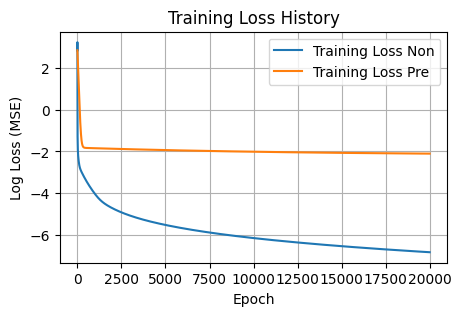

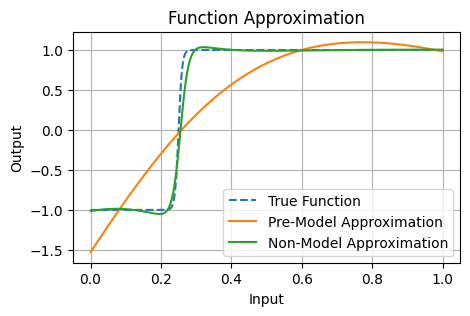

In [ ]:

    # Visualize loss results
    plt.figure(figsize=(5, 3))
    plt.plot(np.log(loss_history_non), label='Training Loss Non')
    plt.plot(np.log(loss_history_pre), label='Training Loss Pre')
    plt.xlabel('Epoch')
    plt.ylabel('Log Loss (MSE)')
    plt.title('Training Loss History')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Visualize results
    # Generate test points
    X_test = torch.linspace(0, 1, 500, device=device).unsqueeze(1)

    # Create predictions
    with torch.no_grad():
        y_pre = net_pre.forward(X_test, net_pre.theta)
        y_non = net_non.forward(X_test, net_non.theta)

    # Move to CPU for plotting
    X_test_cpu = X_test.cpu().numpy()
    y_pre_cpu = y_pre.cpu().numpy()
    y_non_cpu = y_non.cpu().numpy()

    # True function values
    y_true = u4(X_test_cpu)

    # Create plot
    plt.figure(figsize=(5, 3))
    plt.plot(X_test_cpu, y_true, label='True Function', linestyle='--')
    plt.plot(X_test_cpu, y_pre_cpu, label='Pre-Model Approximation')
    plt.plot(X_test_cpu, y_non_cpu, label='Non-Model Approximation')
    plt.xlabel('Input')
    plt.ylabel('Output')
    plt.title('Function Approximation')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
loss_history_non[1]

278.0775451660156

In [ ]:
loss_history_pre[1]

10.192155838012695

## The LOOPs

Pre/no-pre only:   0%|          | 0/5 [00:00<?, ?it/s]

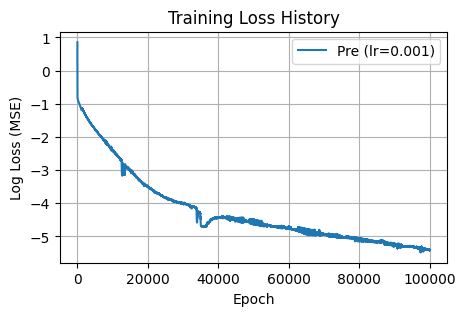

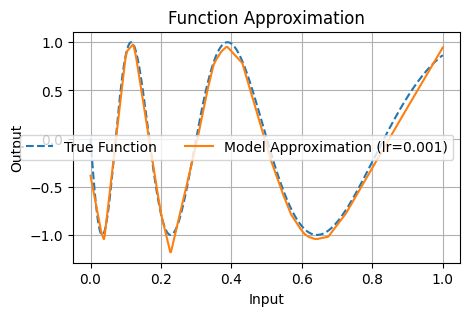

In [ ]:
from tqdm.auto import tqdm

if __name__ == "__main__":
    # Configuration
    target = u6
    lr_grid = [1e-3, 5e-3, 1e-2, 5e-2, 1e-1]
    width = 50
    m = 400
    max = 100000
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    base_seed = 42

    init_method = 'kaiming'
    # Preconditioner
    B1 = create_preconditioner_for_cube_torch(width, device=device)
    # B2 = create_preconditioner_B2_with_T_torch(width, device=device)
    # B3 = create_preconditioner_B3_with_T_torch(width, device=device)
    # B4 = create_preconditioner_B4_with_T_torch(width, device=device)
    # B5 = create_preconditioner_B5_with_T_torch(width, device=device)
    total_params = width**2 + 4 * width + 1
    Vanilla = torch.eye(total_params, device=device)

    preconditioner = B1  ##################

    input_dim = 1
    output_dim = 1

# ------------------ DATA (fixed across LRs) ------------------ #
    rng = np.random.default_rng(seed=42)
    # Generate data
    X_np = np.random.uniform(0, 1, (m, input_dim))
    y_np = target(X_np)
    # Convert to tensors
    X = torch.tensor(X_np, dtype=torch.float32, device=device)
    y = torch.tensor(y_np, dtype=torch.float32, device=device)


    X_test = torch.linspace(0, 1, 500, device=device).unsqueeze(1)
    y_true = target(X_test.cpu().numpy())
# ------------------------------------------------------------- #
    def make_net():
        net_pre = PreconditionedNetwork(
            input_dim=input_dim,
            hidden_dim1=width,
            hidden_dim2=width,
            output_dim=output_dim,
            activation1=torch.relu,
            activation2=torch.relu,
            init_method=init_method,
            device=device
        )
        return net_pre

    all_loss_histories = []
    all_final_pred = []

    # Sweep ---------------------------------------------------- #
    for i, lr in enumerate(tqdm(lr_grid, desc = "Pre/no-pre only")):
        seed = base_seed
        net_i = make_net()

        loss_history_i = net_i.train(X, y, preconditioner, lr=lr, max_iter=max, tol=1e-6)
        all_loss_histories.append((float(lr), np.asarray(loss_history_i, dtype=float)))

        # Plot Loss Curve
        plt.figure(figsize=(5, 3))
        plt.plot(np.log(loss_history_i), label=f'Pre (lr={lr:.3g})')
        plt.xlabel('Epoch')
        plt.ylabel('Log Loss (MSE)')
        plt.title('Training Loss History')
        plt.legend()
        plt.grid(True)

        # Plot approximation
        with torch.no_grad():
            y_pred = net_i.forward(X_test, net_i.theta).cpu().numpy()
        all_final_pred.append((float(lr), y_pred))

        plt.figure(figsize=(5, 3))
        X_test_cpu = X_test.cpu().numpy()
        plt.plot(X_test_cpu, y_true, label='True Function', linestyle='--')
        plt.plot(X_test_cpu, y_pred, label=f'Model Approximation (lr={lr:.3g})')
        plt.xlabel('Input')
        plt.ylabel('Output')
        plt.title('Function Approximation')
        plt.legend(ncol=2)
        plt.grid(True)
        plt.show()

# -------- overall ---------------------------------------------------- #
figA = plt.figure(figsize=(5, 3))
for lr, hist in all_loss_histories:
    plt.plot(np.log(hist), label=f'Pre (lr={lr:.3g})')
plt.xlabel('Epoch')
plt.ylabel('Log Loss (MSE)')
plt.title('Training Loss History Cross LRs')
plt.legend()
plt.grid(True)
plt.show()


figB = plt.figure(figsize=(5, 3))
X_test_cpu = X_test.cpu().numpy()
plt.plot(X_test_cpu, y_true, label='True Function', linestyle='--')
for lr, pred in all_final_pred:
    plt.plot(X_test_cpu, pred, label=f'(lr={lr:.3g})')
plt.xlabel('Input')
plt.ylabel('Output')
plt.title('Function Approximation Cross LRs')
plt.legend(ncol=2)
plt.grid(True)
plt.show()






